In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
from pyproj import CRS, Transformer
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
import torchvision.models as models
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter

class Normalizer:
    """
    Image normalization (log1p + robust/global z) + Pandora normalization.
    Fit ONLY on training data to avoid leakage.
    """
    def __init__(self, clip_z=5.0,enforce_nonneg=True):
        self.clip_z = float(clip_z)
        self.enforce_nonneg = bool(enforce_nonneg)
        self.im_mu = None
        self.im_sigma = None       

    def fit_images(self, tif_paths):
        vals = []
        f32min = np.float32(-3.4028235e+38).item()

        for p in tif_paths:
            with rasterio.open(p) as src:
                arr = src.read(1).astype("float64")            
            m = np.isfinite(arr) & (arr > f32min*0.9)
            if self.enforce_nonneg:
                arr = np.where(m, np.maximum(arr, 0.0), np.nan) #clip negatives to zero
                m = np.isfinite(arr) #sanity check
                
            v = np.log1p(arr[m])  # log1p
            if v.size:
                vals.append(v)
        if not vals:
            raise RuntimeError("No valid pixels found to fit image normalizer.")
        allv = np.concatenate(vals)
        mu = np.median(allv)
        iqr = np.percentile(allv, 75) - np.percentile(allv, 25)
        sigma = max(iqr / 1.349, 1e-6)
        self.im_mu, self.im_sigma = float(mu), float(sigma)

    def normalize_image(self, arr_float64):
        f32min = np.float32(-3.4028235e+38).item()
        m = np.isfinite(arr_float64) & (arr_float64 > f32min * 0.9)
        x = arr_float64.copy()
        if self.enforce_nonneg: x[m] = np.maximum(x[m], 0.0)
        z = np.zeros_like(x, dtype=np.float32)
        z[~m] = 0.0
        z[m] = ((np.log1p(x[m]) - self.im_mu) / self.im_sigma)
        z[m] = np.clip(z[m], -self.clip_z, self.clip_z)
        return z

    def denormalize_image(self, z_float32):
        z = np.clip(z_float32.astype("float64"), -5, 5)  # match training range
        return np.expm1(z * self.im_sigma + self.im_mu)


# normalizer.fit_images(train_files)
# np.savez("normalizer_stats.npz",
#          im_mu=normalizer.im_mu, im_sigma=normalizer.im_sigma)


In [2]:
def load_classification_pickle(input_file="/hpc/home/srs108/TEMPO/file_classification_nop.pkl"):
    """Load from pickle"""
    
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    
    return data["complete"], data["partial"], data["blank"]
# save_classification_pickle(complete, partial, blank, output_file="file_classification_nop.pkl")
complete, partial, blank = load_classification_pickle()
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'

z = np.load("normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)

normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

0.9228390289160353


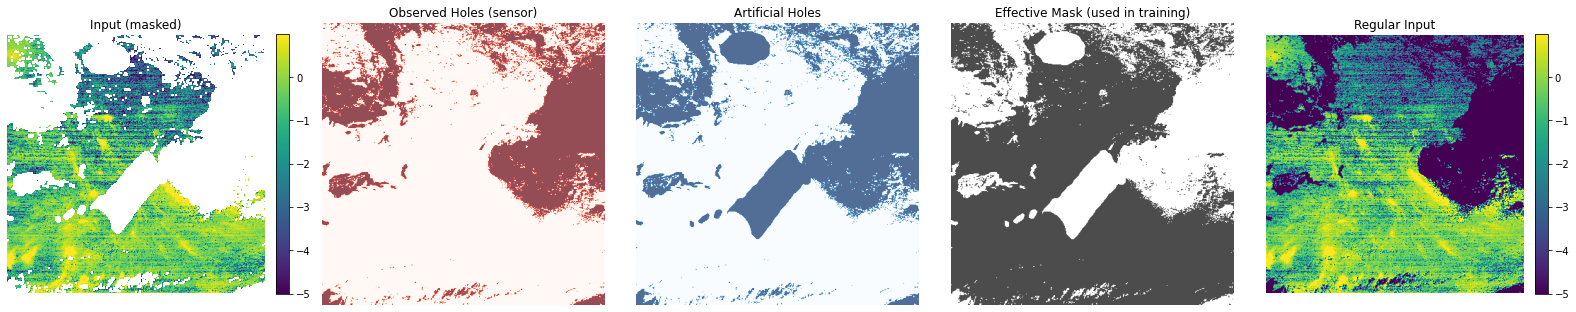

0.9445272759165059


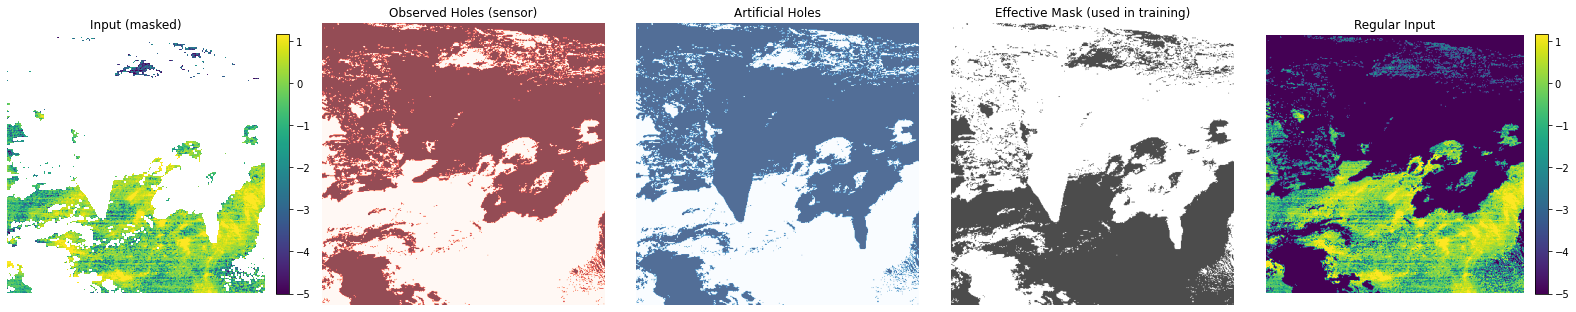

In [25]:

def generate_realistic_gaps_simple(shape, tempo_mask, n_blobs=5, blob_size_range=(80, 200), threshold=0.5):
    """
    Generate realistic cloud-like gap patterns using multi-scale blobs
    
    Parameters:
    - shape: (ny, nx) shape of the output
    - tempo_mask: boolean array where True indicates valid TEMPO pixels
    - n_blobs: number of large-scale cloud structures
    - blob_size_range: tuple of (min, max) blob sizes
    - threshold: threshold for creating gaps (lower = more gaps)
    """
    ny, nx = shape
    field = np.zeros((ny, nx))
    
    # Get valid pixel locations
    valid_locs = np.where(tempo_mask)
    if len(valid_locs[0]) == 0:
        # No valid pixels, return empty mask
        return np.zeros(shape, dtype=np.float32)
    
    # Large-scale cloud structures - more elongated
    for _ in range(n_blobs):
        # Random blob center from valid locations only
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        # Random blob size (much larger)
        blob_size = np.random.randint(*blob_size_range)
        
        # Create elongated cloud-like blob
        y, x = np.ogrid[:ny, :nx]
        
        # Make more elongated by reducing aspect ratio range
        angle = np.random.uniform(0, 2*np.pi)
        aspect_ratio = np.random.uniform(0.1, 0.4)  # More elongated (was 0.3, 1.0)
        
        # Rotate coordinates
        y_rot = (y - cy) * np.cos(angle) - (x - cx) * np.sin(angle)
        x_rot = (y - cy) * np.sin(angle) + (x - cx) * np.cos(angle)
        
        # Create highly elliptical blob
        blob = np.exp(-(y_rot**2 / (2 * (blob_size/1.5)**2) + 
                       (x_rot * aspect_ratio)**2 / (2 * (blob_size/4)**2)))
        
        # Add to field with random intensity
        field += blob * np.random.uniform(0.8, 1.5)
    
    # Add medium-scale details - also elongated
    for _ in range(n_blobs * 2):
        # Random center from valid locations
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        blob_size = np.random.randint(40, 100)
        
        y, x = np.ogrid[:ny, :nx]
        
        # Make medium blobs elongated too
        angle = np.random.uniform(0, 2*np.pi)
        aspect_ratio = np.random.uniform(0.02, 0.06)
        
        y_rot = (y - cy) * np.cos(angle) - (x - cx) * np.sin(angle)
        x_rot = (y - cy) * np.sin(angle) + (x - cx) * np.cos(angle)
        
        blob = np.exp(-(y_rot**2 / (2 * (blob_size/3)**2) + 
                       (x_rot * aspect_ratio)**2 / (2 * (blob_size/5)**2)))
        
        field += blob * np.random.uniform(0.3, 0.8)
    
    # Add fine-scale texture
    for _ in range(n_blobs * 4):
        # Random center from valid locations
        idx = np.random.randint(0, len(valid_locs[0]))
        cy = valid_locs[0][idx]
        cx = valid_locs[1][idx]
        
        blob_size = np.random.randint(15, 40)
        
        y, x = np.ogrid[:ny, :nx]
        blob = np.exp(-((y - cy)**2 + (x - cx)**2) / (2 * (blob_size/5)**2))
        field += blob * np.random.uniform(0.1, 0.5)
    
    # Apply stronger Gaussian smoothing for more diffuse appearance
    field = gaussian_filter(field, sigma=5)
    
    # Add some noise for more realistic texture
    noise = np.random.normal(0, 0.1, field.shape)
    field += gaussian_filter(noise, sigma=3)
    
    # Normalize and apply threshold
    field = (field - field.min()) / (field.max() - field.min())
    gap_mask = (field < threshold).astype(np.float32)
    
    # Constrain gaps to only occur where TEMPO pixels are valid
    gap_mask = gap_mask * tempo_mask.astype(np.float32)
    
    return gap_mask

class TempoInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT


    def sample_vis(self, idx=None):
        if idx is None:
            idx = np.random.randint(len(self))
        sample = self[idx]

        inp_np = sample["img_w_both_masks"][0].numpy()
        mask_obs = sample["known_mask"][0].numpy().astype(bool)
        mask_eff = sample["known_and_fake_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()
        mask_sp = sample['fake_mask'][0].numpy().astype(bool)

        temp_mask = np.sum(mask_obs)
        added_mask = np.sum(mask_sp)
        print(added_mask/temp_mask)
        vmin, vmax = np.percentile(inp_np[np.isfinite(inp_np)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        fig, ax = plt.subplots(1, 5, figsize=(22, 6))

        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_eff), cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[0].set_title("Input (masked)");fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        ax[1].imshow(mask_obs == 0, cmap="Reds", alpha=0.7)
        ax[1].set_title("Observed Holes (sensor)")

        ax[2].imshow(mask_sp == 0, cmap="Blues", alpha=0.7)
        ax[2].set_title("Artificial Holes")
        
        ax[3].imshow(mask_eff == 0, cmap="gray", alpha=0.7)
        ax[3].set_title("Effective Mask (used in training)")
        
        im5 = ax[4].imshow(np.ma.array(targ),
                           cmap=cmap_v, vmin=vmin, vmax=vmax)
        ax[4].set_title("Regular Input")
        fig.colorbar(im5, ax=ax[4], fraction=0.046, pad=0.04)

        for a in ax: a.axis("off")
        plt.tight_layout()
        plt.show()

        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 
    
    
    
        n_blobs= np.random.randint(0,5)
        realistic_gaps = generate_realistic_gaps_simple(
                                shape=(H, W), 
                                tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                n_blobs=n_blobs, 
                                blob_size_range=(20, 74),  # Can make even larger
                                threshold=0.6
                            )

        all_masks = known_mask * realistic_gaps
        img_with_holes = img_n * all_masks
     
        sample = {
            "img_w_both_masks": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real +fake
            "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
            "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
            "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          # salt/pepper holes
            "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
            "path": path,
        }
        return sample
    
# train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, file_list=train_files ,train=True)
# train_ds.sample_vis(300)
# train_ds.sample_vis(7)

In [26]:
class PConv2D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, use_bias=True, activation=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.activation = activation if activation is not None else nn.Identity()

        # Image kernel
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride,
                              padding=kernel_size // 2, bias=use_bias)

        # Fixed mask kernel (all ones)
        self.register_buffer("mask_kernel",
                             torch.ones(1, 1, kernel_size, kernel_size))

    def forward(self, img, mask):
        # Apply mask to image
        img_masked = img * mask

        # Convolution
        img_out = self.conv(img_masked)

        # Convolve mask (counts valid pixels)
        with torch.no_grad():
            mask_out = F.conv2d(mask, self.mask_kernel,
                                stride=self.stride, padding=self.kernel_size // 2)
            mask_out = torch.clamp(mask_out, 0, 1)

        # Normalize by valid ratio
        n = self.kernel_size * self.kernel_size
        mask_ratio = n / (mask_out + 1e-8)
        mask_ratio = mask_ratio * mask_out
        img_out = img_out * mask_ratio

        return self.activation(img_out), mask_out

class PConvUNet2D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()

        # Encoder
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))

        # Bottleneck
        self.bot  = PConv2D(base_ch*8, base_ch*8, activation=nn.LeakyReLU(0.1))

        # Decoder
        self.up3  = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))

        self.up2  = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1  = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        # Final output
        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, img, mask):
        masks = []
        # Encoder
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)

        # Bottleneck
        b, mb = self.bot(e4, m4)

        # Decoder
        d3_in = torch.cat([self.up3(b), e3], dim=1)
        m3_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        d2_in = torch.cat([self.up2(d3), e2], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        d1_in = torch.cat([self.up1(d2), e1], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1


In [43]:
def _load_shapefile_segments_pyshp(shp_path, target_crs):
    prj_path = os.path.splitext(shp_path)[0] + ".prj"
    if os.path.exists(prj_path):
        with open(prj_path, "r") as f:
            wkt = f.read()
        try:
            src_crs = CRS.from_wkt(wkt)
        except Exception:
            src_crs = CRS.from_epsg(4326)
    else:
        src_crs = CRS.from_epsg(4326)

    tgt = target_crs if hasattr(target_crs, "to_wkt") else None
    if tgt is None:
        return None
    
    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    r = shapefile.Reader(shp_path)
    segments = []
    for shapeRec in r.shapeRecords():
        shp = shapeRec.shape
        pts = np.asarray(shp.points, dtype=float)
        if pts.size == 0: 
            continue
        xs, ys = transformer.transform(pts[:,0], pts[:,1])
        pts_t = np.column_stack([xs, ys])
        parts = list(shp.parts) + [len(pts_t)]
        for i in range(len(parts)-1):
            seg = pts_t[parts[i]:parts[i+1]]
            if seg.shape[0] >= 2:
                segments.append(seg)
    return segments


def visualize_batch(epoch,model, dataset, idx, device="cuda", save=False, train = True, shp_path=shp_path, avg_thr=0.2):
    model.eval()
    sample = dataset[idx]   # dict: {"img_in","mask_in","target","path"}
    img    = sample["img_w_both_masks"].unsqueeze(0).to(device)   # [1,1,H,W]
    mask   = sample["known_and_fake_mask"].unsqueeze(0).to(device)  # [1,1,H,W]
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)  #real missing tempo pixels, no fake mask
    target = sample["target"].unsqueeze(0).to(device)   # [1,1,H,W]
    
    if train: 
        fake_mask = sample['fake_mask'].unsqueeze(0).to(device)
        fake_mask = fake_mask[0,0].cpu().numpy().astype(bool)
        
    with torch.no_grad():pred, out_mask  = model(img, mask)
    
    inp_np   = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_np  = mask[0,0].cpu().numpy().astype(bool)   # 1=known
    pred_np  = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np   = normalizer.denormalize_image(target[0,0].cpu().numpy())
    mask_obs = mask_obs[0,0].cpu().numpy().astype(bool)
    
    holes_before = np.count_nonzero(~mask_np)
    holes_filled = np.count_nonzero((~mask_np) & np.isfinite(pred_np))
    fill_frac = 100.0 * holes_filled / max(holes_before, 1)

    path = sample["path"]
    base = os.path.basename(path)
    ts = re.sub(r"\D", "", base)[:14]
    date = datetime.strptime(ts, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width
        xmin, ymin, xmax, ymax = src.bounds

    segments = _load_shapefile_segments_pyshp(shp_path, crs)
    inv = ~tr
    seg_pix = []
    for seg in segments:
        cols, rows = [], []
        for x, y in seg:
            c, r = inv * (x, y)
            cols.append(c)
            rows.append(r)
        seg_pix.append(np.column_stack([cols, rows]))
    segments = seg_pix

    def _add_shape(a, alpha=1.0, color="k"):
        a.add_collection(LineCollection(segments, colors=color, linewidths=0.6, zorder=6, alpha=alpha))
    try:
        gy = ndi.sobel(pred_np, axis=0); gx = ndi.sobel(pred_np, axis=1)
    except Exception:
        gy, gx = np.gradient(pred_np.astype(np.float32))
    grad = np.hypot(gx, gy)

    known_grad = grad[(mask_np) & np.isfinite(grad)]
    if known_grad.size:
        p10, p90 = np.percentile(known_grad, [10, 90])
        scale = max(p90 - p10, 1e-6)
        grad_norm = (grad - p10) / scale
    else:
        grad_norm = grad

    avg_mask = (~mask_np) & (grad_norm < float(avg_thr))  # holes with low texture
    avg_frac = 100.0 * (avg_mask.sum() / max((~mask_np).sum(), 1))

    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")

    finite = np.isfinite(tgt_np)
    vmin, vmax = (np.percentile(tgt_np[finite], [2, 98]) if finite.any() else (0, 1))
    
    inp_ma   = np.ma.array(inp_np,   mask=~mask_np)   # holes → white
    tgt_ma   = np.ma.array(tgt_np,  mask=~np.isfinite(tgt_np))
    pred_ma  = np.ma.array(pred_np, mask=np.isfinite(pred_np))
    
    if train:
        sample_type = "Training"
        fig, ax = plt.subplots(1, 5, figsize=(15, 8))
        
        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_np), cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper")
        ax[0].set_title("Input (holes = white)");_add_shape(ax[0], color="k")
        fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

        im1 = ax[1].imshow(fake_mask, cmap="gray", extent=(0, W, H, 0), origin="upper")
        ax[1].set_title("Train Artificial Mask");_add_shape(ax[1], color="r")

        im2 = ax[2].imshow(np.ma.array(pred_np, mask=~np.isfinite(pred_np)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
        ax[2].set_title(f"Reconstruction {avg_frac:.1f}%");_add_shape(ax[2], color="k")
        fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

        # filled_only: prediction values only in holes
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_np] = pred_np[~mask_np]   # keep values only where mask==0

        # masked array: holes show predictions, known pixels hidden
        im3 = ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
        ax[3].set_title("Filled Values in Holes");_add_shape(ax[3], color="k");fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

        im4 = ax[4].imshow(np.ma.array(tgt_np, mask=~mask_obs), cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper")
        ax[4].set_title("Input (holes = white)");_add_shape(ax[4],color="k")
        fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)
    else:
        sample_type = "Validation"
        fig, ax = plt.subplots(1, 4, figsize = (15,7))
        
        im0 = ax[0].imshow(np.ma.array(inp_np, mask=~mask_np), cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper")
        ax[0].set_title("Input (holes = white)");_add_shape(ax[0], color="k")
        fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)  
        
        im1 = ax[1].imshow(mask_np, cmap="gray", extent=(0, W, H, 0), origin="upper")
        ax[1].set_title("True Missing Mask");_add_shape(ax[1], color="r")

        im2 = ax[2].imshow(np.ma.array(pred_np, mask=~np.isfinite(pred_np)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
        ax[2].set_title(f"Reconstruction {avg_frac:.1f}%");_add_shape(ax[2], color="k")
        fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

        # filled_only: prediction values only in holes
        filled_only = np.full_like(pred_np, np.nan, dtype=np.float32)
        filled_only[~mask_np] = pred_np[~mask_np]   # keep values only where mask==0

        # masked array: holes show predictions, known pixels hidden
        im3 = ax[3].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=(0, W, H, 0), origin="upper", zorder=5)
        ax[3].set_title("Target Image");_add_shape(ax[3], color="k");fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

        
    for a in ax: a.axis("off")

    fig.suptitle(f" {sample_type} image {date}, epoch {epoch}", fontsize=16, y=0.79)
    plt.tight_layout()
    save_path = path.split('/')[-1].split('.')[0]
    if save:
        plt.savefig(f'{save_path}_{sample_type}_epoch_{epoch}.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

  0%|          | 0/1043 [00:00<?, ?it/s]

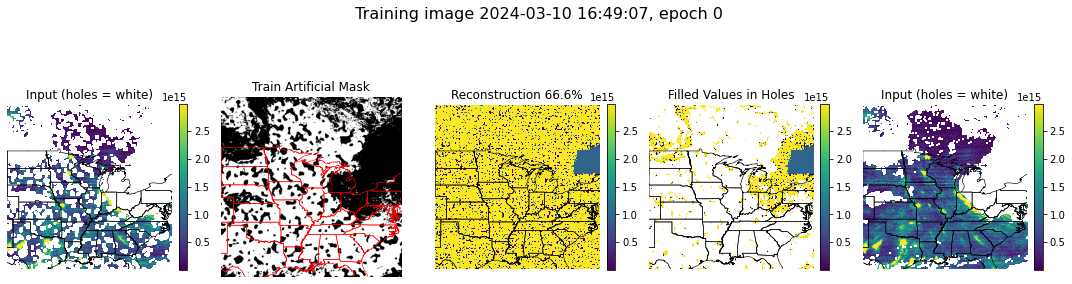

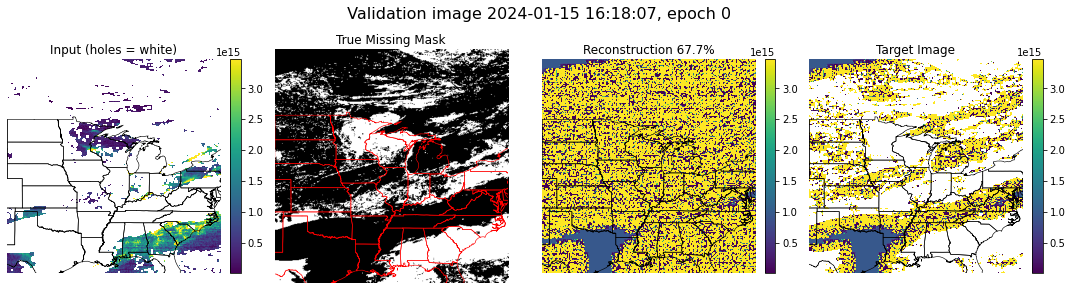

  0%|          | 1/1043 [00:40<11:45:01, 40.60s/it]


KeyboardInterrupt: 

In [44]:
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files)
val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
import csv
import numpy as np
import torch
from tqdm import tqdm

def calculate_metrics(pred, target, mask):
    """Calculate RMSE, MAE, R² for the fake mask regions (where mask=0)"""
    # Only consider the fake mask regions (where mask=0)
    hole_mask = (1 - mask).bool()
    
    # Extract values in the fake mask regions
    if hole_mask.sum() == 0:
        return {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}  # No fake mask regions
        
    pred_holes = pred[hole_mask]
    target_holes = target[hole_mask]
    
    # Calculate metrics
    mse = torch.mean((pred_holes - target_holes) ** 2).item()
    rmse = np.sqrt(mse)
    mae = torch.mean(torch.abs(pred_holes - target_holes)).item()
    
    # For R², convert to numpy for sklearn implementation
    pred_np = pred_holes.detach().cpu().numpy()
    target_np = target_holes.detach().cpu().numpy()
    r2 = r2_score(target_np, pred_np) if len(pred_np) > 1 else 0.0
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def warmup_loss(pred, target, mask):
    hole_mask = 1- mask
    if mask.ndim == 3:  # ensure channel dim
        mask = mask.unsqueeze(1)
    valid_mask = mask.float()

    diff = (pred - target) * valid_mask
    l1_iden = torch.sum(torch.abs(diff)) / (valid_mask.sum() + 1e-8)

    return l1_iden 

def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0

    history = []
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["img_w_both_masks"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            target = batch["target"].cuda()

            pred_t, pred_mask = model(img, mask_aug)
            loss = warmup_loss(pred_t, target, mask)            
            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug)
            for key in batch_metrics:
                train_metrics[key] += batch_metrics[key]
            batch_count += 1
            

        # Average metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["img_w_both_masks"].cuda()
                mask = batch["known_and_fake_mask"].cuda()
                mask_aug = batch["fake_mask"].cuda()  # Add this line to get fake mask
                target = batch["target"].cuda()
                pred, pred_mask = model(img, mask)

                loss = warmup_loss(pred, target, mask)
                val_loss += loss.item()
                
                # Calculate metrics for fake mask regions
                batch_metrics = calculate_metrics(pred, target, mask_aug)
                for key in batch_metrics:
                    val_metrics[key] += batch_metrics[key]
                batch_count += 1
                
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= batch_count
    
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
        print(f"Val metrics - RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}, R²: {val_metrics['r2']:.4f}")
        
                    
        visualize_batch(epoch, model, train_ds, idx=300, device="cuda",train=True, save=True)
        visualize_batch(epoch, model, val_ds, idx=19, device="cuda", train=False, save = True)
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "val_rmse": val_metrics['rmse'],
            "val_mae": val_metrics['mae'],
            "val_r2": val_metrics['r2'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "train_loss", "val_loss", 
                "train_rmse", "train_mae", "train_r2",
                "val_rmse", "val_mae", "val_r2",
                "pred_min_range", "pred_max_range"
            ])
            writer.writeheader()
            writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, train_loader, val_loader, epochs=150, patience=20)